In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import random
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Concatenate, Dot, Lambda, Input
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

In [3]:
def prepare_datasets():
    
    npzfile = np.load('/content/drive/MyDrive/fma_mfcc/shuffled_train.npz') #change path
    print(npzfile.files)
    x_train = npzfile['arr_0']
    y_train = npzfile['arr_1']
    x_train = x_train[0:1000]
    y_train = y_train[0:1000]
    print(x_train.shape, y_train.shape)

    npzfile = np.load('/content/drive/MyDrive/fma_mfcc/shuffled_valid.npz') #change path
    print(npzfile.files)
    x_validation = npzfile['arr_0']
    y_validation = npzfile['arr_1']
    print(x_validation.shape, y_validation.shape)



    #x_train = x_train[... , np.newaxis]
    #x_validation = x_validation[... , np.newaxis]
    #x_test = x_test[... , np.newaxis]
    return x_train, x_validation, y_train, y_validation


In [4]:
x_train, x_validation, y_train, y_validation = prepare_datasets()

['arr_0', 'arr_1']
(1000, 10, 130, 13) (1000,)
['arr_0', 'arr_1']
(799, 10, 130, 13) (799,)


In [5]:
x_test ,  y_test =  x_validation, y_validation
#x_train = x_train[... , np.newaxis]
#x_test = x_test[... , np.newaxis]
print('Training', x_train.shape, x_train.max())
print('Testing', x_test.shape, x_test.max())


Training (1000, 10, 130, 13) 74.13542604597258
Testing (799, 10, 130, 13) 71.31276365835367


In [6]:
'''
Y_train = []
Y_test = []
for i in range(y_train.shape[0]):
  index = tf.argmax(y_train[i], axis=0)
  Y_train.append(index)
y_train = np.array(Y_train)
for i in range(y_test.shape[0]):
  index = tf.argmax(y_test[i], axis=0)
  Y_test.append(index)
y_test = np.array(Y_test)
print(y_train.shape, y_test.shape)
'''
print(y_train[2]) #check values

6


In [7]:
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [142, 111, 139, 119, 122, 109, 129, 129]
test groups: [100, 100, 100, 100, 100, 99, 100, 100]


In [8]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1]*batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i!=c_idx]) for c_idx in group_idx] 
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize
            
        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
            
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)
    
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)

In [13]:
#from kaggle notebook https://www.kaggle.com/kmader/image-similarity-with-siamese-networks
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout, LSTM, Reshape
img_in = Input(shape = x_train.shape[1:], name = 'FeatureNet_ImageInput')
n_layer = img_in

n_layer = Conv2D(68, kernel_size = (3,3), activation = 'relu', padding = 'same')(n_layer)
n_layer = MaxPool2D((2,2), padding = 'same')(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Dropout(0.4)(n_layer)
n_layer = Conv2D(137, kernel_size = (3,3), activation = 'relu')(n_layer)
n_layer = MaxPool2D((3,3), padding = 'same')(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Dropout(0.4)(n_layer)
n_layer = Conv2D(137, kernel_size = (3,3), activation = 'relu', padding = 'same')(n_layer)
n_layer = MaxPool2D((4,4), padding = 'same')(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Dropout(0.4)(n_layer)
n_layer = Conv2D(137, kernel_size = (3,3), activation = 'relu', padding = 'same')(n_layer)
n_layer = MaxPool2D((4,4), padding = 'same')(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Dropout(0.4)(n_layer)

n_layer = Reshape(target_shape=(2,137))(n_layer)

n_layer = LSTM(68, dropout = 0.2, recurrent_dropout = 0.4, return_sequences = True)(n_layer)
n_layer = LSTM(68, dropout = 0.2, recurrent_dropout = 0.4)(n_layer)
n_layer = Dense(32, activation = 'relu')(n_layer)

'''
n_layer = Flatten()(n_layer)
n_layer = Dense(300, activation = 'relu')(n_layer)
n_layer = Dropout(0.2)(n_layer)
n_layer = Dense(100, activation = 'relu')(n_layer)
n_layer = Dropout(0.2)(n_layer)

for i in range(3):
    n_layer = Conv2D(8*2**i, kernel_size = (1,1), activation = 'linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = Conv2D(16*2**i, kernel_size = (1,1), activation = 'linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = MaxPool2D((2,2))(n_layer)
n_layer = Flatten()(n_layer)
n_layer = Dense(32, activation = 'linear')(n_layer)
n_layer = Dropout(0.5)(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Activation('relu')(n_layer)
'''
feature_model = Model(inputs = [img_in], outputs = [n_layer], name = 'FeatureGenerationModel')
feature_model.summary()

Model: "FeatureGenerationModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FeatureNet_ImageInput (Input [(None, 10, 130, 13)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 10, 130, 68)       8024      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 5, 65, 68)         0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 5, 65, 68)         272       
_________________________________________________________________
dropout_9 (Dropout)          (None, 5, 65, 68)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 3, 63, 137)        83981     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 1, 21, 1

In [14]:
from keras.layers import concatenate
img_a_in = Input(shape = x_train.shape[1:], name = 'ImageA_Input')
img_b_in = Input(shape = x_train.shape[1:], name = 'ImageB_Input')
img_a_feat = feature_model(img_a_in)
img_b_feat = feature_model(img_b_in)
combined_features = concatenate([img_a_feat, img_b_feat], name = 'merge_features')
combined_features = Dense(16, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation = 'sigmoid')(combined_features)
similarity_model = Model(inputs = [img_a_in, img_b_in], outputs = [combined_features], name = 'Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ImageA_Input (InputLayer)       [(None, 10, 130, 13) 0                                            
__________________________________________________________________________________________________
ImageB_Input (InputLayer)       [(None, 10, 130, 13) 0                                            
__________________________________________________________________________________________________
FeatureGenerationModel (Functio (None, 32)           527541      ImageA_Input[0][0]               
                                                                 ImageB_Input[0][0]               
__________________________________________________________________________________________________
merge_features (Concatenate)    (None, 64)           0           FeatureGenerationM

In [15]:
similarity_model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['acc'])

def siam_gen(in_groups, batch_size = 32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
        yield [pv_a, pv_b], pv_sim
# we want a constant validation group to have a frame of reference for model performance
valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit_generator(siam_gen(train_groups), 
                               steps_per_epoch = 500,
                               validation_data=([valid_a, valid_b], valid_sim),
                                              epochs = 10,
                                             verbose = True)


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
500/500 [==============================] - 80s 54ms/step - loss: 0.7163 - acc: 0.5224 - val_loss: 0.6868 - val_acc: 0.5405
Epoch 2/10
500/500 [==============================] - 23s 46ms/step - loss: 0.6799 - acc: 0.5600 - val_loss: 0.6782 - val_acc: 0.5684
Epoch 3/10
500/500 [==============================] - 23s 45ms/step - loss: 0.6782 - acc: 0.5680 - val_loss: 0.6767 - val_acc: 0.5688
Epoch 4/10
500/500 [==============================] - 23s 45ms/step - loss: 0.6688 - acc: 0.5875 - val_loss: 0.6736 - val_acc: 0.5791
Epoch 5/10
500/500 [==============================] - 23s 46ms/step - loss: 0.6678 - acc: 0.5880 - val_loss: 0.6863 - val_acc: 0.5435
Epoch 6/10
500/500 [==============================] - 23s 45ms/step - loss: 0.6823 - acc: 0.5565 - val_loss: 0.6696 - val_acc: 0.5981
Epoch 7/10
500/500 [==============================] - 23s 45ms/step - loss: 0.6631 - acc: 0.5994 - val_loss: 0.6797 - val_acc: 0.5571
Epoch 8/10
500/500 [==============================] - 23s 45ms

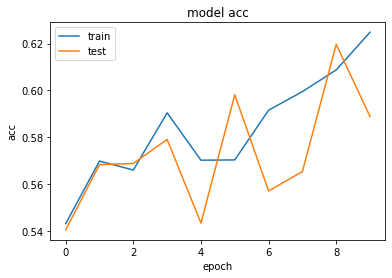

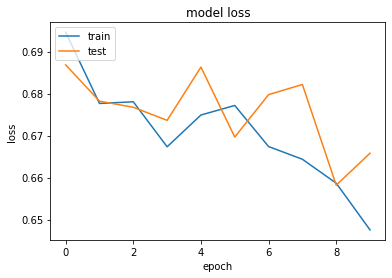

In [16]:
plt.plot(loss_history.history['acc'])
plt.plot(loss_history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(loss_history.history['loss'])
plt.plot(loss_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()